# Calibration

In [2]:
import numpy as np

def compute_fixed_point_r2(x, y):
    """
    Compute R² for best linear fit y = -mx + b where the line must pass through (100, 0).
    This means b = 100m, so the equation becomes y = -mx + 100m = m(100-x)
    
    Parameters:
    x (array-like): x values (percentage points)
    y (array-like): y values (metric values)
    
    Returns:
    tuple: (R² value, slope)
    """
    x = np.array(x)
    y = np.array(y)
    
    # Since we want y = m(100-x), we can find m using least squares
    # m = Σ(y*(100-x)) / Σ((100-x)²)
    shifted_x = 100 - x
    m = np.sum(y * shifted_x) / np.sum(shifted_x ** 2)
    
    # Calculate predicted values
    y_pred = m * shifted_x
    
    # Calculate R²
    
    
    rss = np.sum((y - y_pred) ** 2)
    tss = np.sum((y - np.mean(y)) ** 2)
    r2 = 1 - (rss / tss)
    
    return r2, m

def plot_best_fit_line(ax, x_values, y_values, color, alpha=0.5):
    """
    Plot the best fit line for a given set of points.
    """
    r2, slope = compute_fixed_point_r2(x_values, y_values)
    
    # Generate points for the line
    x_fit = np.array([0, 100])
    y_fit = slope * (100 - x_fit)
    
    # Plot the line
    ax.plot(x_fit, y_fit, '--', color=color, alpha=alpha)
    
    return r2, slope


Metric: ROUGE
No Duplicate: R²=0.650, slope=0.011
Exact Duplicate: R²=-37.472, slope=0.014
Semantic Duplicate: R²=0.693, slope=0.011

Metric: KnowMeM
No Duplicate: R²=-252.867, slope=0.014
Exact Duplicate: R²=-498.097, slope=0.014
Semantic Duplicate: R²=-276.456, slope=0.014

Metric: 1- MIA
No Duplicate: R²=-7.553, slope=0.013
Exact Duplicate: R²=-1219.960, slope=0.014
Semantic Duplicate: R²=-90.213, slope=0.014

Metric: WaterDrum
No Duplicate: R²=0.963, slope=0.011
Exact Duplicate: R²=0.987, slope=0.010
Semantic Duplicate: R²=0.991, slope=0.010


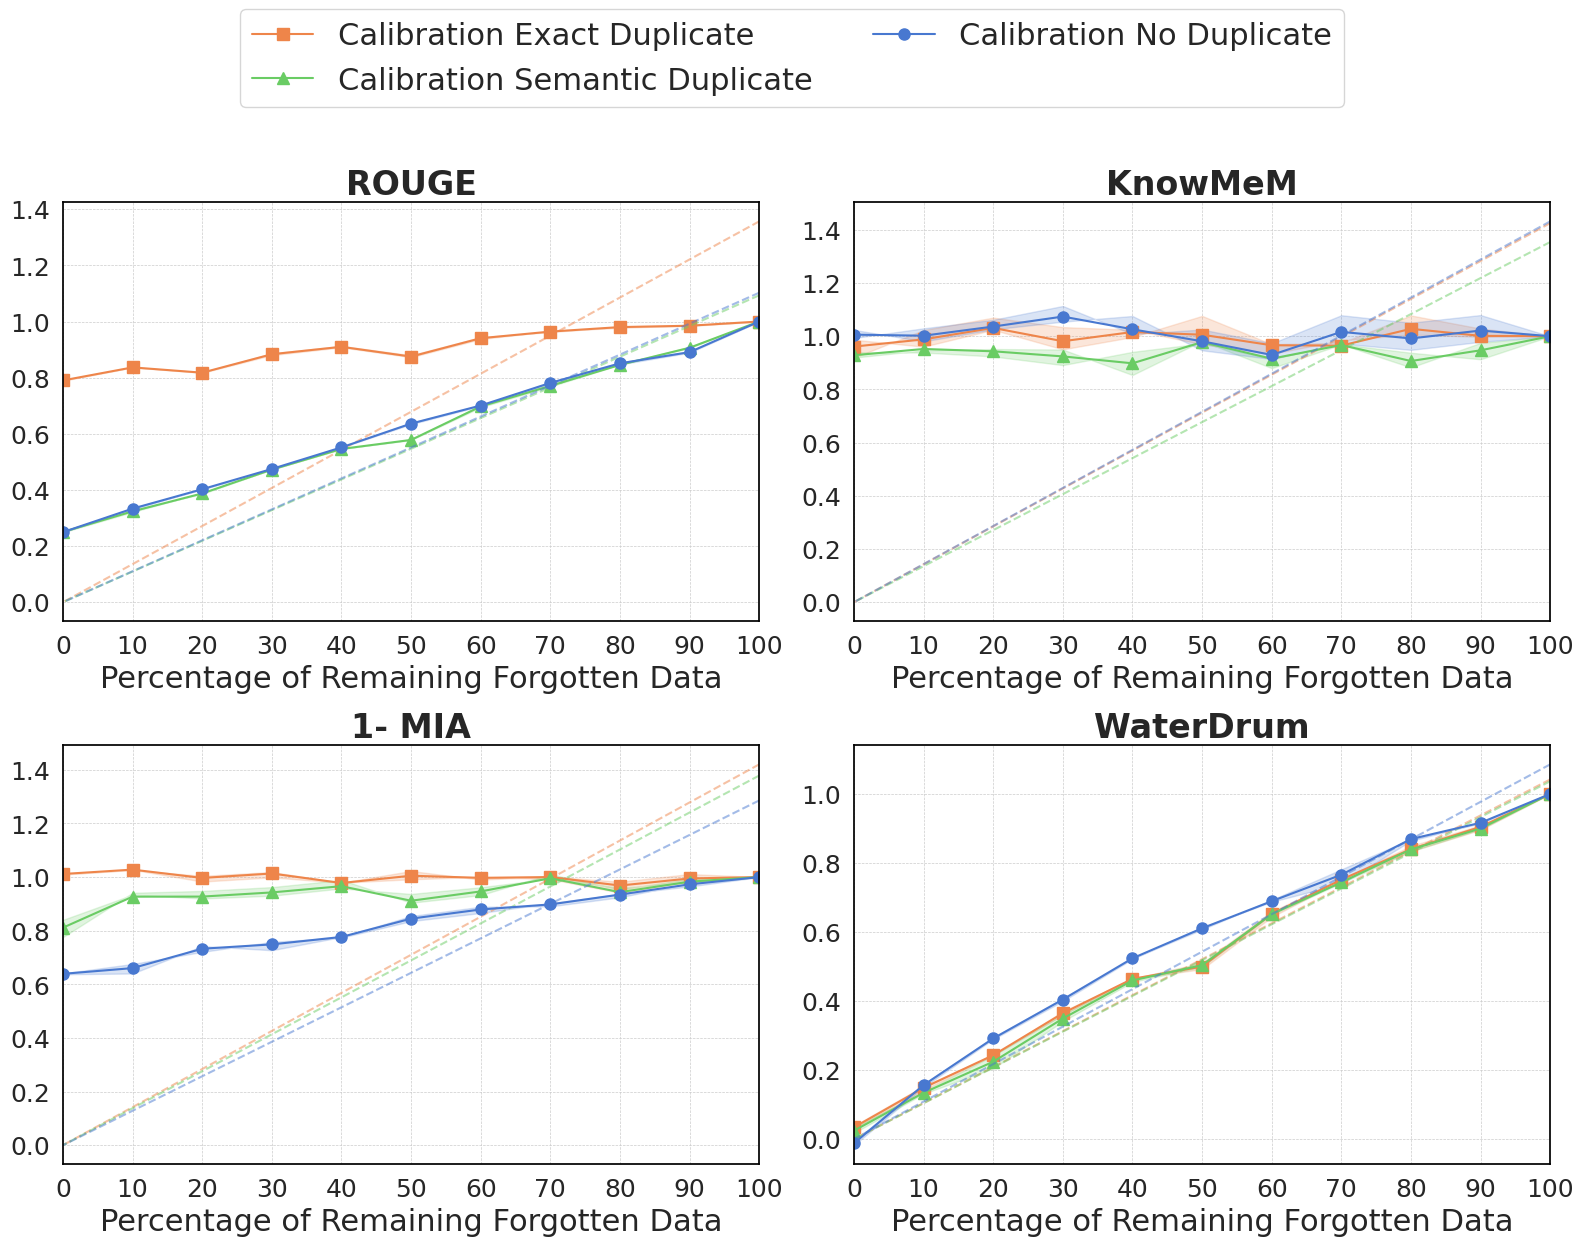

In [ ]:
import json
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import seaborn as sns

# Define the path to the main folder containing results for all seeds
main_folder_path = '~/maplecg_nfs_public/watermark_arxiv/main_results'
seeds = [41, 42, 43]  # List of seeds you want to use
num_pct_values = 11  # As you have percentages from 0 to 10

def scale_by_first_element(array):
    first_element = array[0]
    return array / first_element if first_element != 0 else array

def process_and_plot_metrics(ax, metric_name, y_label, seeds, main_folder_path, num_pct_values):
    # Initialize dictionaries to store arrays for the current metric
    metrics_data = {
        'calibration': np.zeros((len(seeds), num_pct_values)),
        'calibration_duplicate': np.zeros((len(seeds), num_pct_values)),
        'calibration_semduplicate': np.zeros((len(seeds), num_pct_values)),
    }

    # Process calibration data
    for seed_index, seed in enumerate(seeds):
        for eval_type in metrics_data.keys():
            folder_path = os.path.join(main_folder_path, f'seed_{seed}/{eval_type}/eval')
            
            # Existing processing for other metric types
            if metric_name == '1- MIA':
                for pct in range(num_pct_values):
                    filename = f'mia_retraining_{pct}pct.json'
                    filepath = os.path.join(folder_path, filename)
                    with open(filepath, 'r') as file:
                        data = json.load(file)
                        metrics_data[eval_type][seed_index, pct] = 1 - data['forget_holdout_Min-40%']

            elif metric_name == 'KnowMeM':
                for pct in range(num_pct_values):
                    filepath = os.path.join(folder_path, f'knowmem/{pct}/retraining/aggregated.json')
                    with open(filepath, 'r') as file:
                        data = json.load(file)
                        metrics_data[eval_type][seed_index, pct] = data['KnowMem Forget']['mean_rougeL_recall']

            elif metric_name == 'WaterDrum':
                wtm_path = os.path.join(main_folder_path, f'seed_{seed}/watermarked_{eval_type}/watermark_verify/')

                wtm_data = np.load(os.path.join(wtm_path, 'calibration.npy'))
                for pct in range(num_pct_values):
                    metrics_data[eval_type][seed_index, pct] = wtm_data[pct].mean()

            else:  # rougeL_recall
                for pct in range(num_pct_values):
                    filename = f'rouge_retraining_{pct}pct.csv'
                    filepath = os.path.join(folder_path, filename)
                    data = pd.read_csv(filepath)
                    metrics_data[eval_type][seed_index, pct] = data['ROUGE Forget'].mean()

    # Compute averages and percentiles for all metrics
    cal_avg = np.mean(metrics_data['calibration'], axis=0)
    cal_5th = np.percentile(metrics_data['calibration'], 5, axis=0)
    cal_95th = np.percentile(metrics_data['calibration'], 95, axis=0)

    cal_dupl_avg = np.mean(metrics_data['calibration_duplicate'], axis=0)
    cal_dupl_5th = np.percentile(metrics_data['calibration_duplicate'], 5, axis=0)
    cal_dupl_95th = np.percentile(metrics_data['calibration_duplicate'], 95, axis=0)

    cal_sem_dupl_avg = np.mean(metrics_data['calibration_semduplicate'], axis=0)
    cal_sem_dupl_5th = np.percentile(metrics_data['calibration_semduplicate'], 5, axis=0)
    cal_sem_dupl_95th = np.percentile(metrics_data['calibration_semduplicate'], 95, axis=0)

    # if metric_name == 'WaterDrum':
    cal_avg = scale_by_first_element(cal_avg)
    cal_5th = scale_by_first_element(cal_5th)
    cal_95th = scale_by_first_element(cal_95th)
    
    cal_dupl_avg = scale_by_first_element(cal_dupl_avg)
    cal_dupl_5th = scale_by_first_element(cal_dupl_5th)
    cal_dupl_95th = scale_by_first_element(cal_dupl_95th)
    
    cal_sem_dupl_avg = scale_by_first_element(cal_sem_dupl_avg)
    cal_sem_dupl_5th = scale_by_first_element(cal_sem_dupl_5th)
    cal_sem_dupl_95th = scale_by_first_element(cal_sem_dupl_95th)

    # Set up Seaborn style
    sns.set(style="whitegrid")

    # Define distinct colors using a subtle palette
    colors = sns.color_palette("muted", n_colors=6)

    # Reverse `x_values` to go from 100 to 0 for plotting, but we will label them from 0 to 100
    x_values = np.arange(100, -1, -10)

    # Plot calibration_duplicate and its best fit line
    ax.plot(x_values, cal_dupl_avg[::-1], marker='s', label=f'Calibration Exact Duplicate', 
            color=colors[1], linestyle='-', markersize=8)
    ax.fill_between(x_values, cal_dupl_5th[::-1], cal_dupl_95th[::-1], color=colors[1], alpha=0.2)
    r2_dupl, slope_dupl = plot_best_fit_line(ax, x_values, cal_dupl_avg[::-1], colors[1])

    # Plot calibration_semduplicate and its best fit line
    ax.plot(x_values, cal_sem_dupl_avg[::-1], marker='^', label=f'Calibration Semantic Duplicate', 
            color=colors[2], linestyle='-', markersize=8)
    ax.fill_between(x_values, cal_sem_dupl_5th[::-1], cal_sem_dupl_95th[::-1], color=colors[2], alpha=0.2)
    r2_sem, slope_sem = plot_best_fit_line(ax, x_values, cal_sem_dupl_avg[::-1], colors[2])

    # Plot original calibration and its best fit line
    ax.plot(x_values, cal_avg[::-1], marker='o', label=f'Calibration No Duplicate', 
            color=colors[0], linestyle='-', markersize=8)
    ax.fill_between(x_values, cal_5th[::-1], cal_95th[::-1], color=colors[0], alpha=0.2)
    r2_cal, slope_cal = plot_best_fit_line(ax, x_values, cal_avg[::-1], colors[0])

    # Customize the plot
    ax.set_xticks(x_values)  # Keep ticks same to align with reversed data
    ax.set_xticklabels(np.arange(0, 101, 10))  # Change tick labels to go from 0 to 100
    ax.set_xlim([100, 0])  # Explicit x-axis limits ensure plotting direction is reversed
    ax.set_xlabel('Percentage of Remaining Forgotten Data', fontsize=22)
    ax.tick_params(axis='both', labelsize=18)
    ax.set_title(f'{metric_name}', fontsize=24, weight='bold')
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)

    for spine in ax.spines.values():
        spine.set_color('black')

    # Print R² values and slopes
    print(f"\nMetric: {metric_name}")
    print(f"No Duplicate: R²={r2_cal:.3f}, slope={slope_cal:.3f}")
    print(f"Exact Duplicate: R²={r2_dupl:.3f}, slope={slope_dupl:.3f}")
    print(f"Semantic Duplicate: R²={r2_sem:.3f}, slope={slope_sem:.3f}")

# Create a single figure with four subplots in a 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(16, 12))  # Adjusted to a 2x2 grid for improved layout

# Flatten the axes array for easy indexing
axes = axes.flatten()

# Plot for each metric separately
process_and_plot_metrics(axes[0], 'ROUGE', 'ROUGE Forget', seeds, main_folder_path, num_pct_values)
process_and_plot_metrics(axes[1], 'KnowMeM', 'KnowMeM', seeds, main_folder_path, num_pct_values)
process_and_plot_metrics(axes[2], '1- MIA', '1- MIA', seeds, main_folder_path, num_pct_values)
process_and_plot_metrics(axes[3], 'WaterDrum', 'WaterDrum Forget', seeds, main_folder_path, num_pct_values)

# Adjust layout to make room for a single legend
plt.tight_layout(rect=[0, 0, 1, 0.92])

# Create a single legend outside the subplots, above them
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=2, fontsize=22)

plt.show()

# Scaled Calibration


Metric: ROUGE
No Duplicate: R²=0.998, slope=0.010
Exact Duplicate: R²=0.923, slope=0.011
Semantic Duplicate: R²=0.997, slope=0.010

Metric: KnowMeM
No Duplicate: R²=0.006, slope=0.009
Exact Duplicate: R²=-0.331, slope=0.013
Semantic Duplicate: R²=0.101, slope=0.004

Metric: 1- MIA
No Duplicate: R²=0.990, slope=0.010
Exact Duplicate: R²=0.273, slope=0.021
Semantic Duplicate: R²=-0.011, slope=0.012

Metric: WaterDrum
No Duplicate: R²=0.957, slope=0.011
Exact Duplicate: R²=0.994, slope=0.010
Semantic Duplicate: R²=0.995, slope=0.010


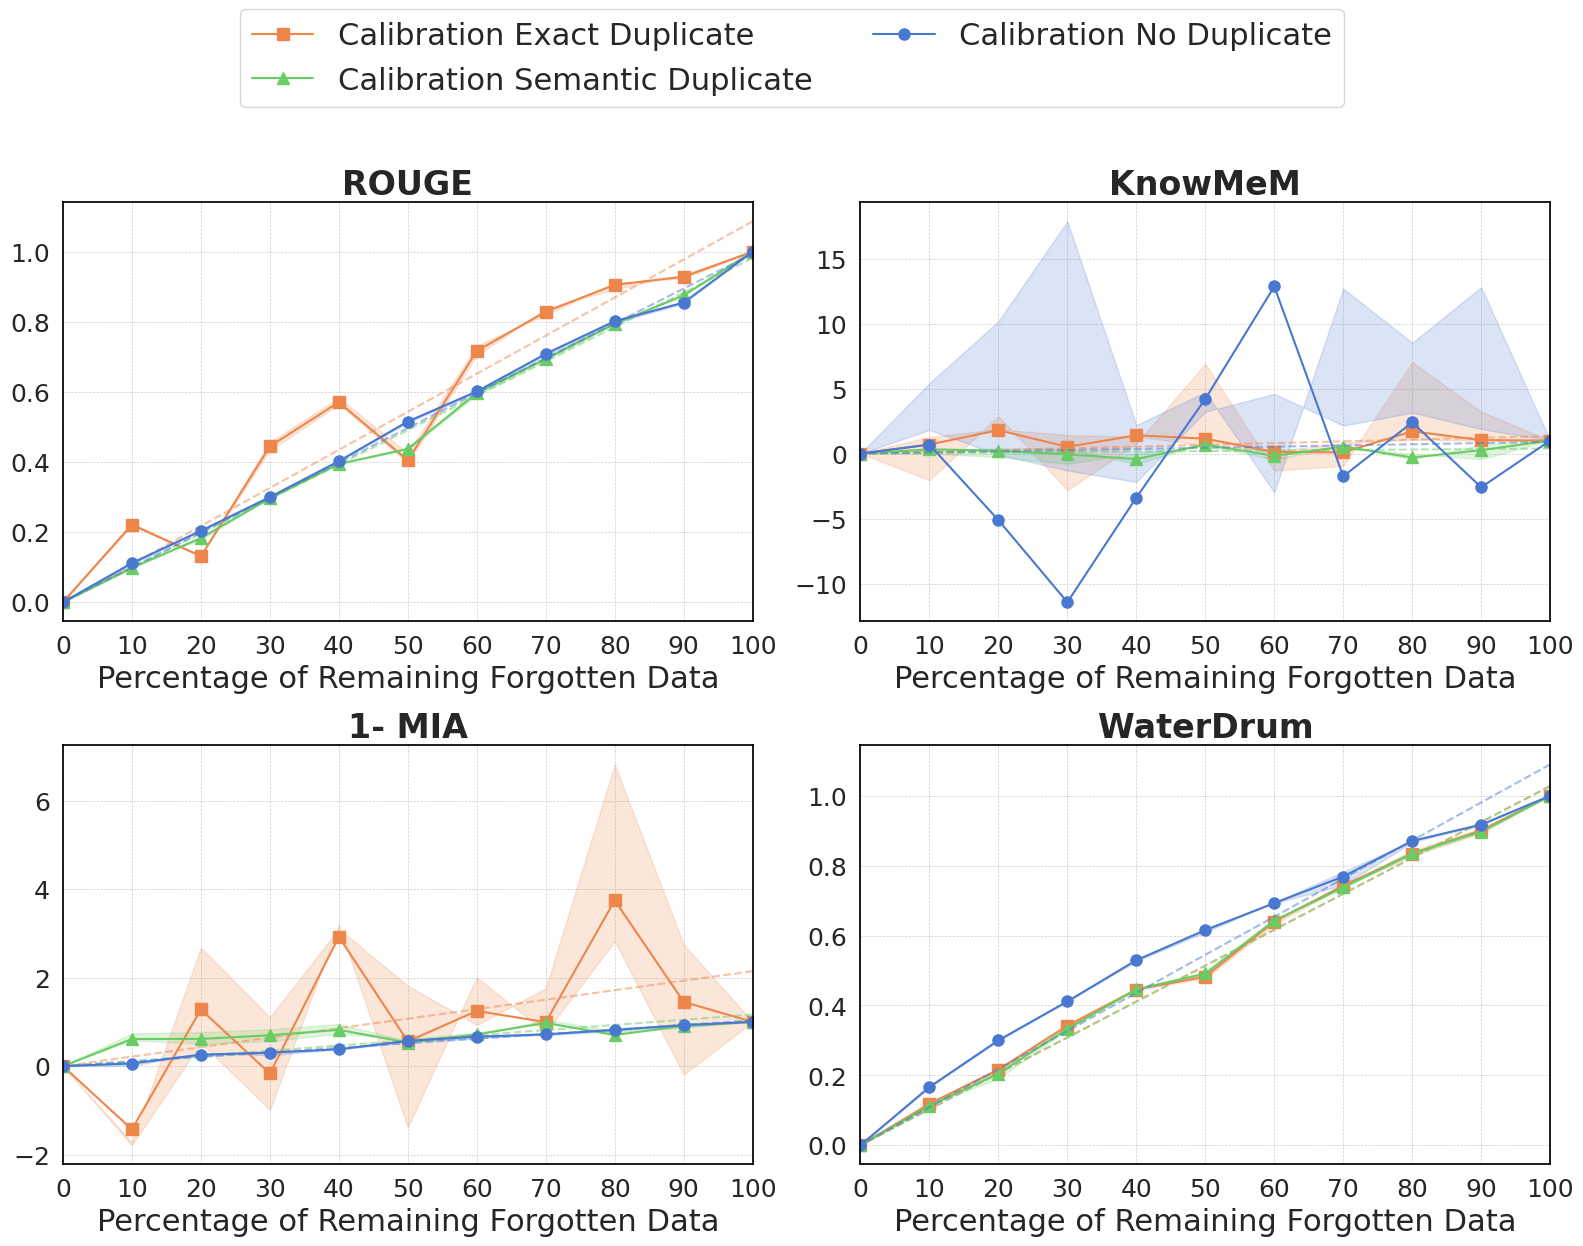

In [ ]:
import json
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import seaborn as sns

# Define the path to the main folder containing results for all seeds
main_folder_path = '~/maplecg_nfs_public/watermark_arxiv/main_results'
seeds = [41, 42, 43]  # List of seeds you want to use
num_pct_values = 11  # As you have percentages from 0 to 10

def scale_by_first_element(array):
    first_element = array[0]
    last_element = array[-1]
    if first_element == last_element:
        return np.ones_like(array)  # Avoids division by zero
    return (array - last_element) / (first_element - last_element)

def process_and_plot_metrics(ax, metric_name, y_label, seeds, main_folder_path, num_pct_values):
    # Initialize dictionaries to store arrays for the current metric
    metrics_data = {
        'calibration': np.zeros((len(seeds), num_pct_values)),
        'calibration_duplicate': np.zeros((len(seeds), num_pct_values)),
        'calibration_semduplicate': np.zeros((len(seeds), num_pct_values)),
    }

    # Process calibration data
    for seed_index, seed in enumerate(seeds):
        for eval_type in metrics_data.keys():
            folder_path = os.path.join(main_folder_path, f'seed_{seed}/{eval_type}/eval')

            # Existing processing for other metric types
            if metric_name == '1- MIA':
                for pct in range(num_pct_values):
                    filename = f'mia_retraining_{pct}pct.json'
                    filepath = os.path.join(folder_path, filename)
                    with open(filepath, 'r') as file:
                        data = json.load(file)
                        metrics_data[eval_type][seed_index, pct] = 1 - data['forget_holdout_Min-40%']

            elif metric_name == 'KnowMeM':
                for pct in range(num_pct_values):
                    filepath = os.path.join(folder_path, f'knowmem/{pct}/retraining/aggregated.json')
                    with open(filepath, 'r') as file:
                        data = json.load(file)
                        metrics_data[eval_type][seed_index, pct] = data['KnowMem Forget']['mean_rougeL_recall']

            elif metric_name == 'WaterDrum':
                wtm_path = os.path.join(main_folder_path, f'seed_{seed}/watermarked_{eval_type}/watermark_verify/')

                wtm_data = np.load(os.path.join(wtm_path, 'calibration.npy'))
                for pct in range(num_pct_values):
                    metrics_data[eval_type][seed_index, pct] = wtm_data[pct].mean()

            else:  # rougeL_recall
                for pct in range(num_pct_values):
                    filename = f'rouge_retraining_{pct}pct.csv'
                    filepath = os.path.join(folder_path, filename)
                    data = pd.read_csv(filepath)
                    metrics_data[eval_type][seed_index, pct] = data['ROUGE Forget'].mean()

    # Compute averages and percentiles for all metrics
    cal_avg = np.mean(metrics_data['calibration'], axis=0)
    cal_5th = np.percentile(metrics_data['calibration'], 5, axis=0)
    cal_95th = np.percentile(metrics_data['calibration'], 95, axis=0)

    cal_dupl_avg = np.mean(metrics_data['calibration_duplicate'], axis=0)
    cal_dupl_5th = np.percentile(metrics_data['calibration_duplicate'], 5, axis=0)
    cal_dupl_95th = np.percentile(metrics_data['calibration_duplicate'], 95, axis=0)

    cal_sem_dupl_avg = np.mean(metrics_data['calibration_semduplicate'], axis=0)
    cal_sem_dupl_5th = np.percentile(metrics_data['calibration_semduplicate'], 5, axis=0)
    cal_sem_dupl_95th = np.percentile(metrics_data['calibration_semduplicate'], 95, axis=0)

    # if metric_name == 'WaterDrum':
    cal_avg = scale_by_first_element(cal_avg)
    cal_5th = scale_by_first_element(cal_5th)
    cal_95th = scale_by_first_element(cal_95th)

    cal_dupl_avg = scale_by_first_element(cal_dupl_avg)
    cal_dupl_5th = scale_by_first_element(cal_dupl_5th)
    cal_dupl_95th = scale_by_first_element(cal_dupl_95th)

    cal_sem_dupl_avg = scale_by_first_element(cal_sem_dupl_avg)
    cal_sem_dupl_5th = scale_by_first_element(cal_sem_dupl_5th)
    cal_sem_dupl_95th = scale_by_first_element(cal_sem_dupl_95th)

    # Set up Seaborn style
    sns.set(style="whitegrid")

    # Define distinct colors using a subtle palette
    colors = sns.color_palette("muted", n_colors=6)

    # Reverse `x_values` for plotting
    x_values = np.arange(100, -1, -10)

    # Plot calibration_duplicate and its best fit line
    ax.plot(x_values, cal_dupl_avg[::-1], marker='s', label=f'Calibration Exact Duplicate', 
            color=colors[1], linestyle='-', markersize=8)
    ax.fill_between(x_values, cal_dupl_5th[::-1], cal_dupl_95th[::-1], color=colors[1], alpha=0.2)
    r2_dupl, slope_dupl = plot_best_fit_line(ax, x_values, cal_dupl_avg[::-1], colors[1])

    # Plot calibration_semduplicate and its best fit line
    ax.plot(x_values, cal_sem_dupl_avg[::-1], marker='^', label=f'Calibration Semantic Duplicate', 
            color=colors[2], linestyle='-', markersize=8)
    ax.fill_between(x_values, cal_sem_dupl_5th[::-1], cal_sem_dupl_95th[::-1], color=colors[2], alpha=0.2)
    r2_sem, slope_sem = plot_best_fit_line(ax, x_values, cal_sem_dupl_avg[::-1], colors[2])

    # Plot original calibration and its best fit line
    ax.plot(x_values, cal_avg[::-1], marker='o', label=f'Calibration No Duplicate', 
            color=colors[0], linestyle='-', markersize=8)
    ax.fill_between(x_values, cal_5th[::-1], cal_95th[::-1], color=colors[0], alpha=0.2)
    r2_cal, slope_cal = plot_best_fit_line(ax, x_values, cal_avg[::-1], colors[0])

    # Customize the plot
    ax.set_xticks(x_values)
    ax.set_xticklabels(np.arange(0, 101, 10))  # Change tick labels from 0 to 100
    ax.set_xlim([100, 0])  # Ensure x-axis is plotted in reverse direction
    ax.set_xlabel('Percentage of Remaining Forgotten Data', fontsize=22)
    ax.tick_params(axis='both', labelsize=18)
    ax.set_title(f'{metric_name}', fontsize=24, weight='bold')
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)

    for spine in ax.spines.values():
        spine.set_color('black')

    # Print R² values and slopes
    print(f"\nMetric: {metric_name}")
    print(f"No Duplicate: R²={r2_cal:.3f}, slope={slope_cal:.3f}")
    print(f"Exact Duplicate: R²={r2_dupl:.3f}, slope={slope_dupl:.3f}")
    print(f"Semantic Duplicate: R²={r2_sem:.3f}, slope={slope_sem:.3f}")

# Create a single figure with four subplots in a 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(16, 12))  # Adjusted to a 2x2 grid for improved layout

# Flatten the axes array for easy indexing
axes = axes.flatten()

# Plot for each metric separately
process_and_plot_metrics(axes[0], 'ROUGE', 'ROUGE Forget', seeds, main_folder_path, num_pct_values)
process_and_plot_metrics(axes[1], 'KnowMeM', 'KnowMeM', seeds, main_folder_path, num_pct_values)
process_and_plot_metrics(axes[2], '1- MIA', '1- MIA', seeds, main_folder_path, num_pct_values)
process_and_plot_metrics(axes[3], 'WaterDrum', 'WaterDrum Forget', seeds, main_folder_path, num_pct_values)

# Adjust layout to make room for a single legend
plt.tight_layout(rect=[0, 0, 1, 0.92])

# Create a single legend outside the subplots, above them
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=2, fontsize=22)

plt.show()